# Sentiment Analysis on Florist Customer Churn Feedback


---
**Author**  :
- Ayudha Amari Hirtranusi
- Danisa Rahadian A
- Muhammad Erico R
- Yuliana Theresa

**Dataset**       : [Florist Customer Churn](https://huggingface.co/datasets/iammkb2002/florist_customer_churn/viewer)  

**Hugging Face**  : [Link](https://huggingface.co/spaces/amariayudha/Predictix)

## A. Introduction

This notebook focuses on analyzing customer sentiment for a florist business. We'll use the dataset 'florist_customer_cleaned.csv' to perform sentiment analysis on customer feedback.



**Problem Statement**  

In today's competitive market, businesses strive to understand their customers' sentiments to enhance service quality and foster customer loyalty. However, manually analyzing customer feedback from various channels such as surveys, social media, and reviews is both time-consuming and prone to human error. This inefficiency can lead to delayed insights, making it challenging for companies to respond promptly to customer needs and preferences.

**Predictix** addresses this challenge by leveraging advanced Natural Language Processing (NLP) techniques to automatically analyze and interpret customer feedback. By processing large volumes of textual data, Predictix can accurately determine the sentiment behind customer reviews, enabling businesses to gain real-time insights and make informed decisions to improve their products and services.

**Objectives:**

1. Understand customer sentiment through their feedback
2. Build a model to classify sentiment in customer reviews
3. Feed the sentiment to the next model to classify whether the customer will churn or not.

**Proposed Solution:**

Predictix utilizes machine learning and NLP algorithms to preprocess and analyze customer feedback data. The system employs techniques such as tokenization, stopword removal, and sentiment classification using models like BERT and LSTM. By automating the sentiment analysis process, Predictix enables businesses to efficiently monitor and respond to customer sentiments, ultimately enhancing the overall customer experience and driving business growth.

**Expected Outcomes:**

- **Accurate Sentiment Classification:** High accuracy in determining the sentiment of customer reviews.
- **Actionable Insights:** Provision of detailed insights that can inform strategic business decisions.
- **Scalability:** Ability to handle and process large volumes of data from multiple sources.
- **Predictive Churn Analysis:** Utilize sentiment analysis results to predict customer churn.




## B. Libraries

Firstly, we will imports all the necessary libraries for our sentiment analysis project. We're using pandas and numpy for data manipulation, matplotlib and seaborn for visualization, and various machine learning and NLP tools. We also load pre-trained BERT models and tokenizers, and download required NLTK resources. The warnings are suppressed to keep the output clean.

In [1]:
# Importing necessary libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import textwrap

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Input, Dense, TextVectorization, Embedding, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
import random

# Natural Language Processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Import pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# Load pre-trained BERT tokenizer and model
from transformers import BertTokenizer, BertForSequenceClassification

# Configuration 
import os
import warnings
warnings.filterwarnings('ignore')

Next up, we will set torch to use with GPU (this makes our BERT model that we will utilized with pytorch learns faster). Also, we already implement the tensorflow to run with GPU too but didn't need to explicitly write the code because it's already set with GPU when installing the cudnn/cuda-tool-kit.

In [2]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    # If GPU is available, print its name
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    # If no GPU is available, inform that training will use CPU
    print("No GPU available. Training will run on CPU.")

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device that will be used for computations
print(f"Using device: {device}")

# Note: This setup allows the code to automatically use GPU acceleration
# if available, which can significantly speed up deep learning computations.
# If no GPU is available, it gracefully falls back to using the CPU.

GPU: NVIDIA GeForce RTX 3060 Laptop GPU is available.
Using device: cuda


The output confirms that a GPU is available and will be used for computations, which will enhance the training speed and efficiency.

## C. Data Loading & Cleaning

Here we load our dataset 'florist_customer_cleaned.csv' into a pandas DataFrame. We display the first few rows to get an initial look at our data, check the basic information about the DataFrame, and examine if there are any missing values that need to be addressed.
We've created a new DataFrame df_sentiment that focuses only on the 'feedback' and 'sentiment' columns, which are the most relevant for our sentiment analysis task. This allows us to concentrate on the text data and its associated sentiment label.

Firstly, we will load our dataset 'florist_customer_cleaned.csv' into a pandas DataFrame. We display the first few rows to get an initial look at our data.

In [3]:
# Read the dataset
df = pd.read_csv('florist_customer_cleaned.csv')
df.head()

,customer_id,churn,tenure,monthly_charges,total_charges,contract,payment_method,feedback,sentiment,topic
0,CUST001,True,12,3000000.0,36000000.0,one year,credit card,Love the variety of flowers!,positive,bouquet preferences
1,CUST002,True,4,3505000.0,14200000.0,month-to-month,electronic check,Delivery was often late,negative,delivery issues
2,CUST003,False,20,29990000.0,59908000.0,two year,bank transfer,Great service and quality,positive,general feedback
3,CUST004,True,2,3200000.0,6400000.0,month-to-month,mailed check,Not enough variety,negative,bouquet preferences
4,CUST005,True,15,2805000.0,42705000.0,one year,credit card,Beautiful arrangements every time,positive,general feedback


From the output above, we can see that this is the column name and their description.

| **Column Name**    | **Description**                                           |
|--------------------|-----------------------------------------------------------|
| `customer_id`      | Unique identifier for each customer                      |
| `churn`            | Indicates whether the customer has left (`True`/`False`) |
| `tenure`           | Number of months the customer has been with the company   |
| `monthly_charges`  | Amount charged to the customer monthly (in local currency)|
| `total_charges`    | Total amount charged to the customer over their tenure    |
| `contract`         | Type of contract the customer has (e.g., one year, month-to-month, two year) |
| `payment_method`   | Payment method used by the customer (e.g., credit card, electronic check) |
| `feedback`         | Customer feedback comments regarding the service or product |
| `sentiment`        | Sentiment of the feedback (`positive`/`negative`)        |
| `topic`            | Topic category of the feedback (e.g., bouquet preferences, delivery issues, general feedback) |


This cell provides a summary of our DataFrame, including the number of entries, column names, non-null counts, and data types. This information helps us understand the size of our dataset and identify any potential data quality issues, such as missing values or incorrect data types.

In [4]:
# Display the basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1000 non-null   object 
 1   churn            1000 non-null   bool   
 2   tenure           1000 non-null   int64  
 3   monthly_charges  1000 non-null   float64
 4   total_charges    1000 non-null   float64
 5   contract         1000 non-null   object 
 6   payment_method   1000 non-null   object 
 7   feedback         1000 non-null   object 
 8   sentiment        1000 non-null   object 
 9   topic            1000 non-null   object 
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 71.4+ KB


Here, we can see that there are 10 columns with appropriate data types. Also, ther are 1000 entries, indicating the dataset contains 1000 customer records. All columns have 1000 non-null entries, suggesting no missing values. but we will check it further.

We check for missing values in our dataset. This step is crucial in data preprocessing as missing data can significantly impact our analysis and model performance. The output will show the number of null values in each column, if any.


In [5]:
# Check for missing values
df.isnull().sum()

customer_id        0
churn              0
tenure             0
monthly_charges    0
total_charges      0
contract           0
payment_method     0
feedback           0
sentiment          0
topic              0
dtype: int64

All columns have zero missing values, indicating that the dataset is complete and ready for analysis without the need for imputation.


We create a new DataFrame 'df_sentiment' that focuses only on the 'feedback' and 'sentiment' columns. This step narrows down our dataset to the essential information needed for sentiment analysis. We then display the first few rows of this new DataFrame to confirm our selection.


In [6]:
# Focus on relevant columns for sentiment analysis
df_sentiment = df[['feedback', 'sentiment']]

In [7]:
# Display the first 5 rows of df_sentiment
df_sentiment.head()

,feedback,sentiment
0,Love the variety of flowers!,positive
1,Delivery was often late,negative
2,Great service and quality,positive
3,Not enough variety,negative
4,Beautiful arrangements every time,positive


from displays the first five rows of the df_sentiment DataFrame above, we can verify that it contains the correct columns.

## D. Exploratory Data Analysis (EDA)


In this section, we perform some exploratory data analysis. We visualize the distribution of sentiments in our dataset using a bar plot. We also create word clouds for both positive and negative feedback, which give us a quick visual representation of the most frequent words in each sentiment category.
This visualization shows us the top 50 most frequent words in our dataset. This can help us identify common themes or topics in the customer feedback, and might also reveal potential stopwords that we should consider removing in our text preprocessing step.

`Distribution of Customer Sentiment & World Cloud of Positive and Negative Feedback`

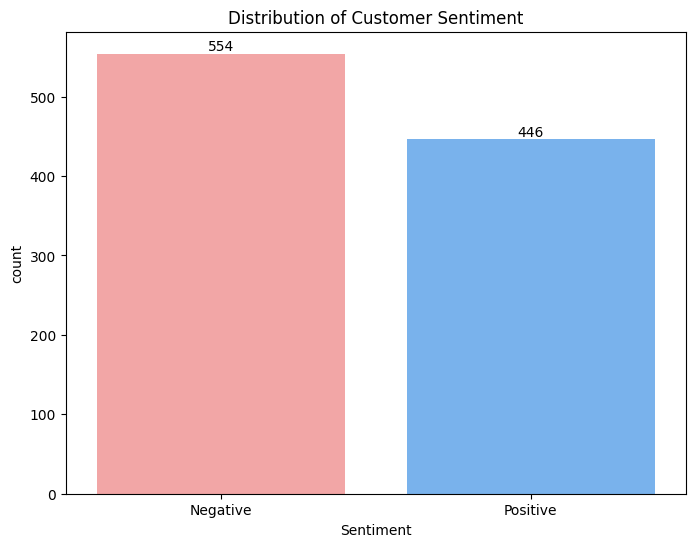

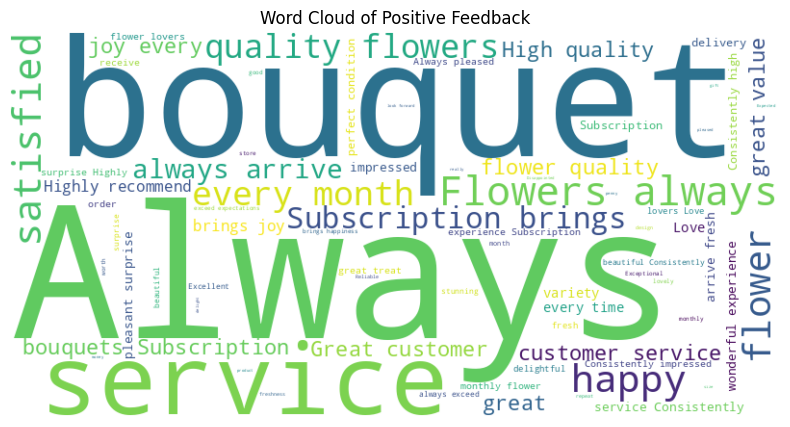

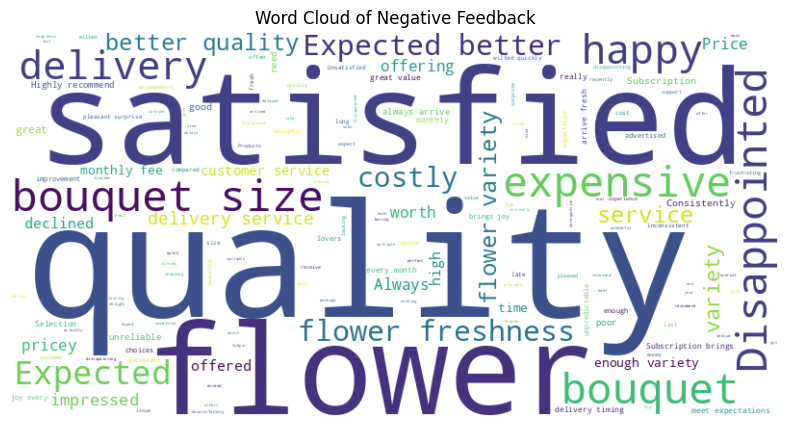

In [ ]:
# Distribution of sentiment
plt.figure(figsize=(8, 6))
colors = ['#FF9999', '#66B2FF']  # Light red for negative, light blue for positive
ax = sns.countplot(x='sentiment', data=df_sentiment, palette=colors)
plt.title('Distribution of Customer Sentiment')
plt.xlabel('Sentiment')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points')

# Customize x-axis labels
plt.xticks([0, 1], ['Negative', 'Positive'])

plt.show()

# Word cloud for positive feedback
positive_feedback = ' '.join(df_sentiment[df_sentiment['sentiment'] == 1]['feedback'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_feedback)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Feedback')
plt.show()

# Word cloud for negative feedback
negative_feedback = ' '.join(df_sentiment[df_sentiment['sentiment'] == 0]['feedback'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_feedback)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Feedback')
plt.show()

> Insight: Distribution of Customer Sentiment

The bar chart above illustrates the distribution of customer sentiment based on their feedback. The data reveals the following key insights:

1. **Higher Negative Sentiment**: Out of the total feedback collected, 554 instances are classified as negative, indicating that a majority of customers have an unfavorable opinion about the service or product.
2. **Substantial Positive Feedback**: There are 446 instances of positive sentiment, which shows that a significant number of customers are satisfied with the service or product.
3. **Imbalance in Sentiment**: The higher number of negative feedback compared to positive feedback suggests that there are notable issues that need to be addressed to improve overall customer satisfaction.

This distribution highlights the importance of focusing on the negative feedback to identify and rectify the underlying issues. By addressing the concerns raised in the negative feedback, the company can work towards enhancing the customer experience and potentially converting negative sentiments into positive ones.

> Insight: Word Cloud of Positive Feedback

The word cloud above visualizes the most frequently mentioned words in positive customer feedback. The larger the word, the more frequently it appears in the feedback. Key insights derived from this word cloud include:

1. **Frequent Mention of `Bouquet` and `Flowers`**: The words `bouquet` and `flowers` are prominently featured, indicating that customers often appreciate the quality and variety of the floral arrangements provided.
2. **Emphasis on `Service`**: The word `service` appears frequently, suggesting that customers are generally satisfied with the level of service they receive.
3. **Positive Adjectives**: Words like `always,` `happy,` `satisfied,` `quality,` and `great` are commonly used, reflecting a high level of customer satisfaction and positive experiences.
4. **Subscription Model**: The word `subscription` is also notable, indicating that customers value the subscription service offered, which likely contributes to their positive feedback.
5. **Consistency and Reliability**: Terms such as `always,` `every month,` and `arrive` suggest that customers appreciate the consistency and reliability of the service.

Overall, the word cloud highlights the aspects of the service that customers find most appealing, such as the quality of the bouquets, the reliability of the service, and the positive experiences associated with the subscription model. These insights can help the company understand what they are doing well and continue to focus on these strengths.

> Insight: Word Cloud of Negative Feedback

The word cloud above visualizes the most frequently mentioned words in negative customer feedback. The larger the word, the more frequently it appears in the feedback. Key insights derived from this word cloud include:

1. Concerns About `Quality` and `Flowers`: The words `quality` and `flowers` are prominently featured, indicating that many customers have concerns about the quality of the flowers they receive.
2. Issues with `Delivery`: The word `delivery` appears frequently, suggesting that delivery-related issues are a common source of dissatisfaction among customers.
3. `Expensive` and `Costly`: Terms like `expensive` and `costly` are notable, indicating that some customers feel the service or products are overpriced.
4. `Bouquet Size` and `Variety`: Words such as `bouquet size` and `variety` suggest that customers are not satisfied with the size of the bouquets or the variety of flowers offered.
5. `Disappointed` and `Expected Better`: The presence of words like `disappointed` and `expected better` reflects unmet expectations and general dissatisfaction with the service or product.
6. Mixed Sentiment on `Satisfied`: Interestingly, the word `satisfied` appears in the negative feedback, possibly indicating that some customers are expressing conditional satisfaction or comparing their current experience to previous, more positive experiences.

Overall, the word cloud highlights several areas for improvement, including flower quality, delivery service, pricing, bouquet size, and variety. Addressing these issues can help the company enhance customer satisfaction and reduce negative feedback.

## E. Data Preprocessing


We've defined a comprehensive text preprocessing function that performs several cleaning steps on our text data. This includes:

- **Case folding**
- **Removing special characters and numbers**
- **Tokenization**
- **Stopword removal**
- **Lemmatization**

This cleaned text will be more suitable for our machine learning models.

We apply our text preprocessing function to the `feedback` column and create a new `processed_feedback` column. This allows us to keep both the original and processed versions of the text for comparison and further analysis.

Before applying our text preprocessing function, we will visualize the most frequent words in our dataset to gain insights into the raw text data. This step is crucial for several reasons:

1. **Understanding the raw data**: It gives us a clear picture of the most common terms used in customer feedback before any processing.

2. **Identifying potential stopwords**: Some frequently occurring words might not carry significant meaning and could be added to our stopword list.

3. **Recognizing key themes**: The most frequent words can highlight the main topics or concerns in customer feedback.

4. **Informing feature engineering**: Understanding frequent terms can help in creating relevant features for our machine learning models.

We will use a bar plot to visualize the top 50 most frequent words, which will provide a clear and interpretable representation of word frequencies in our dataset. This visualization will be created using `matplotlib`, with the x-axis representing individual words and the y-axis showing their respective counts.

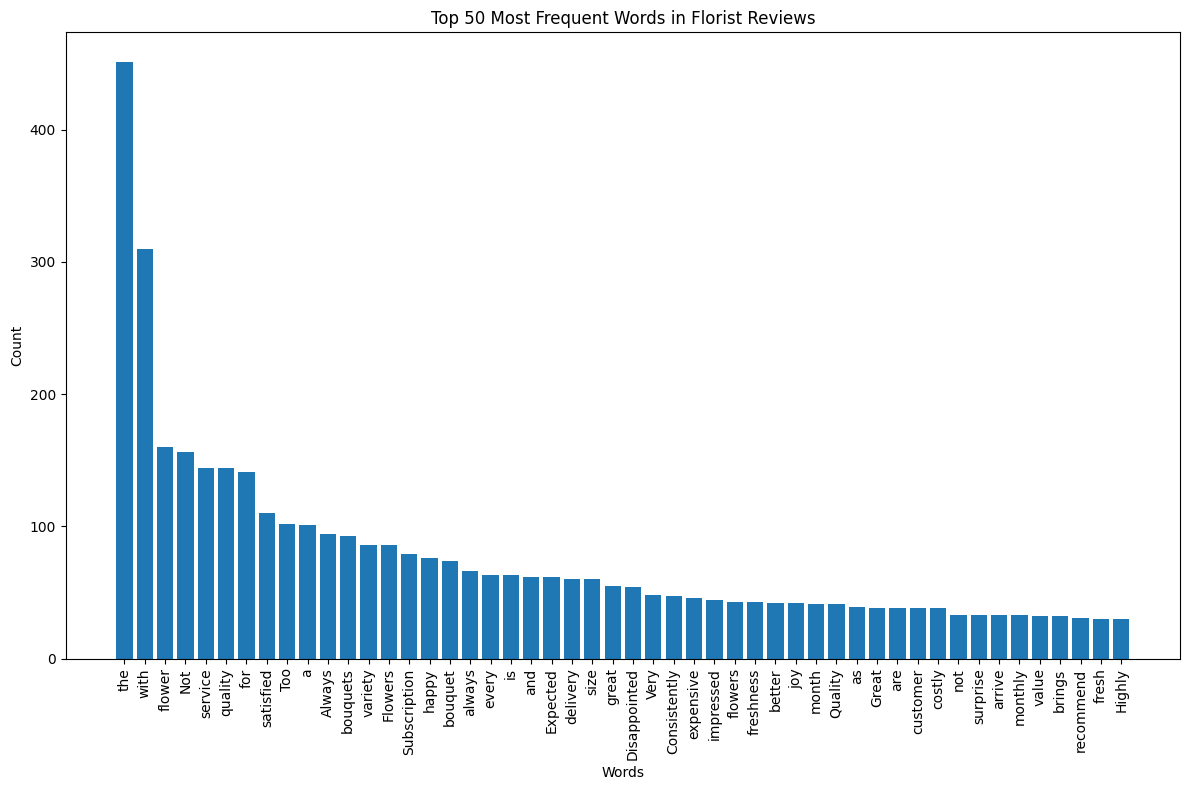

In [9]:
# Show the most frequent words


df_sentiment['feedback_list'] = df_sentiment['feedback'].apply(lambda x: str(x).split())
high_all = Counter([item for sublist in df_sentiment['feedback_list'] for item in sublist])
feedback_high_all = pd.DataFrame(high_all.most_common(50))
feedback_high_all.columns = ['Words', 'Count']
feedback_high_all.style.background_gradient(cmap='Greens')


plt.figure(figsize=(12, 8))
plt.bar(feedback_high_all['Words'], feedback_high_all['Count'])
plt.xticks(rotation=90)
plt.title('Top 50 Most Frequent Words in Florist Reviews')
plt.xlabel('Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

After identifying the most frequent words, we will enhance our text preprocessing by incorporating **custom stopwords**. This step is crucial for several reasons:

1. **Improved Data Cleaning**: By including frequently occurring but less meaningful words as stopwords, we can effectively remove noise from our text data.

2. **Domain-Specific Relevance**: Custom stopwords allow us to tailor our preprocessing to the specific context of florist reviews, ensuring that common but non-informative terms in this domain are filtered out.

3. **Feature Optimization**: Removing these high-frequency, low-information words can help in creating more meaningful features for our machine learning models.

4. **Dimensionality Reduction**: By eliminating these common words, we reduce the dimensionality of our text data, potentially improving the performance and efficiency of our models.

5. **Focus on Meaningful Content**: This process helps in highlighting the more significant and unique aspects of each review, making it easier for our models to identify important patterns and sentiments.

The custom stopwords will be added to our existing list of standard English stopwords. Words like `flowers`, `bouquet`, and `delivery` will be included in this custom list, as they are common across most reviews and may not provide distinctive information for sentiment analysis or topic modeling.

This enhanced stopword list will be utilized in the `text_preprocessing` function, ensuring that these domain-specific, high-frequency words are effectively removed during the preprocessing stage. This refined approach will lead to a more focused and relevant representation of the review content for our subsequent analysis and modeling tasks.

In [10]:
# Define Stopwords
stpwds_en = set(stopwords.words('english'))

# Add custom stopwords based on the top 50 words
custom_stopwords = ['flowers', 'flower', 'bouquet', 'delivery', 'service', 'ordered',
                    'beautiful', 'great', 'time', 'received', 'order', 'arrived',
                    'nice', 'love', 'arrangement', 'good', 'day', 'delivered',
                    'look', 'really', 'always', 'would', 'get', 'like', 'one']

# Extend the stopwords
# stpwds_en.update(custom_stopwords)

# Convert to list for easier use in other functions
stpwds_en = list(stpwds_en)

print(f"Total number of stopwords: {len(stpwds_en)}")
print("Sample of custom stopwords added:")
print(custom_stopwords[:10])

Total number of stopwords: 179
Sample of custom stopwords added:
['flowers', 'flower', 'bouquet', 'delivery', 'service', 'ordered', 'beautiful', 'great', 'time', 'received']


*Note: Through trial and error experimentation, adding custom stopwords resulted in decreased model performance. This may be due to the limited number of tokens in our feedback data (approximately 18 tokens maximum in a sentence). Therefore, we have commented out the custom stopwords in the previous cell and decided not to implement them in the final version.*

Next, we will create a function that performs the overall text preprocessing as follows

In [11]:
# Create A Function for Text Preprocessing
def text_preprocessing(text):
    """
    Preprocesses the input text by applying various cleaning and normalization techniques.

    Parameters:
    text (str): The input text to be preprocessed.

    Returns:
    str: The preprocessed text.
    Example usage:
    >>> text = "I love @FlowerShop's #beautiful bouquet! Order at http://flower.com"
    >>> preprocessed_text = text_preprocessing(text)
    >>> print(preprocessed_text)
    'love beautiful bouquet order'
    """
    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub("@[A-Za-z0-9_]+", " ", text)

    # Hashtags removal
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\n", " ", text)

    # Remove possessive 's
    text = re.sub(r"'s\b","", text)

    # Remove Numbers
    text = re.sub(r"\d+", " ", text)

    # Remove Punctuation
    text = re.sub(r"[^\w\s]", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Delete words that are only 1 or 2 characters long
    text = re.sub(r"\b\w{1,2}\b", " ", text)

    # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
    text = re.sub("[^A-Za-z\s']", " ", text)

    # Schema: tokenize first/split word -> stopwords
    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_en]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Combining Tokens
    text = ' '.join(tokens)

    return text

The `text_preprocessing` function is a comprehensive text cleaning and normalization tool designed to prepare text data for natural language processing tasks. Here's what it does:

1. **Case Folding**: Converts all text to lowercase for consistency.
2. **Mention Removal**: Eliminates @mentions often found in social media text.
3. **Hashtag Removal**: Removes #hashtags from the text.
4. **Newline Removal**: Replaces newline characters with spaces.
5. **Apostrophe Handling**: Removes possessive 's from words.
6. **Number Removal**: Eliminates all numeric digits from the text.
7. **Punctuation Removal**: Strips out all punctuation marks.
8. **Whitespace Trimming**: Removes leading and trailing whitespace.
9. **URL Removal**: Eliminates web links (both http and www formats).
10. **Short Word Removal**: Deletes words that are only 1 or 2 characters long.
11. **Non-letter Removal**: Removes any characters that aren't letters (e.g., emoticons, symbols).
12. **Tokenization**: Splits the text into individual words.
13. **Stopword Removal**: Eliminates common words that often don't contribute much meaning.
14. **Lemmatization**: Reduces words to their base or dictionary form.

The function processes the text through these steps sequentially, resulting in clean, normalized text that's ready for further analysis or modeling. This preprocessing is crucial for improving the quality and consistency of text data, which can significantly impact the performance of NLP models.

Also, notice how we use **lemmatization** here instead of **stemming** because lemmatization is better at **detecting word forms** and is more suitable for **English language processing**. Our dataset contains various **verb forms** like **v2** (past tense), **v+ing** (present participle), and **base forms**. The **NLTK library** provides comprehensive support for English language relevance, making lemmatization a more **appropriate choice** for our text preprocessing.


Then we apply our text preprocessing function to the '`feedback`' column and create a new '`processed_feedback`' column. This allows us to keep both the original and processed versions of the text for comparison and further analysis.

In [12]:
# Apply text preprocessing to the 'feedback' column
df_sentiment['processed_feedback'] = df_sentiment['feedback'].apply(text_preprocessing)

In [13]:
# Dataframe after processed feedback
df_sentiment[['feedback', 'processed_feedback']].head()

,feedback,processed_feedback
0,Love the variety of flowers!,love variety flower
1,Delivery was often late,delivery often late
2,Great service and quality,great service quality
3,Not enough variety,enough variety
4,Beautiful arrangements every time,beautiful arrangement every time


## F. Model Building


In this crucial step of our sentiment analysis project, we already prepare our data for model training. This process involves several key steps to ensure our model can effectively learn and generalize from the available data.

First, we split our dataset into features and target variables. The features, denoted as `X`, consist of the `processed_feedback` column, which contains the cleaned and preprocessed text data. The target variable, `y`, is derived from the `sentiment` column. It's important to note that we convert the sentiment labels to numerical values for compatibility with most machine learning algorithms. Specifically, we map **positive** sentiment to `1` and **negative** sentiment to `0`. This binary representation allows our model to interpret the sentiment as a classification problem.

After preparing our features and target, we implement a strategic data splitting approach. We divide our dataset into three distinct subsets: **training**, **validation**, and **test** sets. The training set, which comprises the largest portion of our data, is used to teach our model the underlying patterns in the sentiment data. The validation set serves as a checkpoint during the training process, allowing us to tune hyperparameters and prevent overfitting. Finally, the test set, which remains untouched until the very end, provides an unbiased evaluation of our model's final performance. We use the `train_test_split` function to perform this division, ensuring that each subset maintains the same proportion of positive and negative sentiments through stratification. This careful splitting ensures we have separate, representative data for each stage of our model development process, from initial training to final performance evaluation.

In [14]:
# Prepare the data
X = df_sentiment['processed_feedback']
y = df['sentiment']

# Convert sentiment labels to numerical values
sentiment_map = {'positive': 1, 'negative': 0}
y = y.map(sentiment_map)

# Split the data into training, validation, and testing sets with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

The data is strategically split into three sets: **training** (85%), **validation** and **testing** (15%). This separation is crucial for robust model development and evaluation:

1. **Training Set** (85%): The largest portion is allocated to training, allowing the model to learn from a substantial amount of data. This set is used to teach the model underlying patterns and relationships in the sentiment data.

2. **Validation Set** (15%): This set serves as a checkpoint during the training process. It's used for **`fine-tuning`** the model, selecting optimal **`hyperparameters`**, and preventing **`overfitting`**. The size allows for reliable performance estimation without significantly reducing the training data.

3. **Testing Set** (15%): Reserved for the final evaluation, this set provides an **`unbiased`** estimate of the model's performance on new, unseen data. The 15% allocation ensures a sufficient sample for reliable performance metrics.

The split ratios are chosen to balance between having enough data for training and reserving adequate data for validation and testing. **`Stratification`** is applied during splitting to maintain the same proportion of positive and negative sentiments in each set, ensuring representative samples and mitigating potential bias due to class imbalance.

Next, we will employ **three distinct approaches** or classifiers for sentiment analysis:

1. **Random Forest Classifier**: We utilize this to assess the effectiveness of a **simple approach**. We aim to determine if a basic model suffices for our problem. The question we're addressing is: Can we achieve satisfactory results using only a straightforward model?

2. **LSTM Classifier**: Long Short-Term Memory (LSTM) networks are often considered a **benchmark for NLP tasks**. By using LSTM, we can evaluate whether our data is suitable for more advanced neural network architectures. This helps us understand if our dataset is rich enough to benefit from LSTM's capabilities.

3. **BERT Classifier**: BERT (Bidirectional Encoder Representations from Transformers) represents the **state-of-the-art in NLP**. Its performance typically surpasses both LSTM and Random Forest models. By implementing BERT, we can gauge its performance on our specific dataset and compare it to the other approaches.

In essence, we're employing these three classifiers (`Random Forest`, `LSTM`, and `BERT`) to conduct a comprehensive sentiment analysis. This strategy allows us to observe the performance gradient from a very simple model, through a benchmark model, to a cutting-edge model. This approach provides valuable insights into the complexity required for our specific sentiment analysis task.


### 1. Random Forest Classifier

In our sentiment analysis task, we begin by employing a **Random Forest Classifier**, a robust and versatile machine learning algorithm. This approach allows us to create a straightforward yet effective model for predicting the sentiment of text data. The key to this process lies in transforming the textual information into a numerical format that the model can interpret and learn from.

To achieve this transformation, we utilize the **Term Frequency-Inverse Document Frequency (TF-IDF)** vectorization technique. TF-IDF is a statistical measure that evaluates the importance of a word to a document in a collection or corpus. By applying TF-IDF, we convert our `X_train`, `X_val`, and `X_test` datasets into numerical feature vectors (`X_train_tfidf`, `X_val_tfidf`, `X_test_tfidf`). This vectorization process captures the significance of words in our sentiment-laden texts, allowing the Random Forest model to discern patterns and make predictions. The `max_features` parameter in our `TfidfVectorizer` is set to `50000`, striking a balance between capturing a wide range of features and managing computational complexity.

 Following this, we train our `RandomForestClassifier` with `100` estimators, providing a solid foundation for learning the intricacies of sentiment in our dataset. The choice of n_estimators is set to `100` to ensure a good balance between model complexity and performance also this choice is based on the fact that the number of estimators should be greater than or equal to the number of features in the dataset. We won't pay really attention to this model because we just want to know how is the performance of a simple model here.

In [15]:
# Create and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=50000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train_tfidf)

# Evaluate the model on the training set
print("Training Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred)))
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=['negative', 'positive']))

Training Accuracy: 0.92

Training Classification Report:
              precision    recall  f1-score   support

    negative       0.96      0.89      0.92       400
    positive       0.87      0.96      0.91       322

    accuracy                           0.92       722
   macro avg       0.92      0.92      0.92       722
weighted avg       0.92      0.92      0.92       722



Predictions are made on the training set, and the model's performance is evaluated using accuracy and a classification report, which includes precision, recall, f1-score, and support for each class.

The training accuracy is `92%`, indicating that the model fits the training data well. The classification report shows high precision and recall for both 'negative' and 'positive' classes, suggesting balanced performance.

In [16]:
# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val_tfidf)

# Evaluate the model on the validation set
print("Validation Accuracy: {:.2f}".format(accuracy_score(y_val, y_val_pred)))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['negative', 'positive']))

Validation Accuracy: 0.91

Validation Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.87      0.91        71
    positive       0.86      0.95      0.90        57

    accuracy                           0.91       128
   macro avg       0.91      0.91      0.91       128
weighted avg       0.91      0.91      0.91       128



The validation accuracy is `91%`, which is close to the training accuracy, indicating that the model generalizes well to unseen data. The classification report shows that both classes are predicted with high precision and recall.

In [17]:
# Make predictions on the test set
y_test_pred = rf_model.predict(X_test_tfidf)

# Evaluate the model on the test set
print("Test Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['negative', 'positive']))

Test Accuracy: 0.87

Test Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.83      0.87        83
    positive       0.81      0.91      0.86        67

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



The test accuracy is `87%`, slightly lower than the training and validation accuracies. This indicates a small drop in performance on the test set, which is expected. The classification report still shows good precision and recall, suggesting the model maintains reasonable performance on new data.

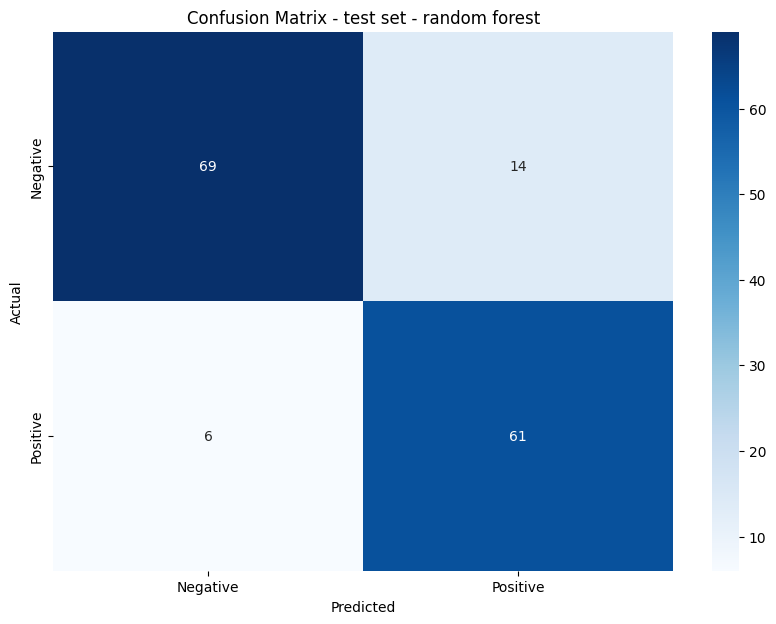

In [18]:
# Plotting confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - test set - random forest')
plt.show()

The confusion matrix displayed represents the performance of a **random forest classifier** on a test set, specifically designed to predict sentiment as either "negative" or "positive." Here's a detailed analysis of the confusion matrix:

1. **Overall Composition**:
   - The matrix is divided into four quadrants:
     - **True Negative (`TN`)**: The top left quadrant (69) represents the number of correctly predicted negative sentiments.
     - **False Positive (`FP`)**: The top right quadrant (14) indicates the number of positive predictions that were actually negative.
     - **False Negative (`FN`)**: The bottom left quadrant (6) shows the number of negative predictions that were actually positive.
     - **True Positive (`TP`)**: The bottom right quadrant (61) represents the number of correctly predicted positive sentiments.

2. **Accuracy**:
   - The overall accuracy of the model can be calculated as the sum of true predictions (`TN` + `TP`) divided by the total number of cases. In this case, `(69 + 61) / (69 + 14 + 6 + 61) = 130 / 150 = 0.867` or **86.7%**. This indicates a relatively high overall accuracy.

3. **Precision and Recall**:
   - **Precision (Positive Predictive Value)** for the positive class is calculated as `TP / (TP + FP) = 61 / (61 + 14) = 61 / 75 ≈ 0.813` or **81.3%**. This shows the accuracy of positive predictions.
   - **Recall (True Positive Rate)** for the positive class is `TP / (TP + FN) = 61 / (61 + 6) = 61 / 67 ≈ 0.910` or **91.0%**. This indicates the ability of the classifier to identify all relevant instances.

4. **Specificity and Sensitivity**:
   - **Specificity (True Negative Rate)** is `TN / (TN + FP) = 69 / (69 + 14) = 69 / 83 ≈ 0.831` or **83.1%**. This measures the proportion of actual negatives that are correctly identified.
   - **Sensitivity** is the same as the Recall for the positive class.

5. **Analysis of Errors**:
   - The model has a higher number of false positives (`FP`=14) compared to false negatives (`FN`=6). This could suggest a slight bias towards predicting positives, or it could indicate that some negative sentiments share characteristics common among positives, leading to classification errors.

6. **Conclusion**:
   - The baseline model, or a very simple one model turns out already showing a great performance with **`87%` accuracy on the test set and `92%` on the train set** showing a **`GOOD-FIT`**. But maybe, we can improve it later on with more complex model like LSTM or even BERT, this good performance already on the simple model means our data is relatively easy, and it's true, when we take a look at the dataset. There are only like average 5-10 words in a sentence. That is why a simple model is already enough but we will compare it again later on.

This analysis helps in understanding the model's performance and guiding further model refinement to reduce misclassifications, especially in reducing the false positives.

Overall, the performance of our model using simple random forest can be seen as follows :

| Model          | Train Accuracy | Validation Accuracy | Test Accuracy |
|----------------|----------------|---------------------|---------------|
| Random Forest  | 92%            | 91%                 | 87%           |

The model is already showing a good-fit, but maybe we can imrpove it with more complex model like LSTM or BERT


### 2. LSTM

Next up, we will build an **LSTM model** with a hope to get better performance than the simple model (random forest) which we build before. But first, we will create a `CountVectorizer()` to get the number of `vocab` that we had

In [19]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3521 stored elements and shape (722, 226)>

In [20]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  226
Maximum Sentence Length :  18 tokens


Here, we can see that it turns out there are only about **226 total vocabulary** in our dataset, and the number of maximum token in a sentence is **18 tokens**. This could be the reason why previous model already works really well (combination of TF-IDF vectorizer and Random Forest). But what if the model meets a feedback that are really different than what our model trained on? that is why we still build a complex model like LSTM and BERT.

In [21]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

Next, we will implement **Word embedding** that represents words as continuous vectors in a space where similar words are closer together. This method captures semantic relationships between words, unlike simpler methods like TF-IDF before. The next step is to apply word embedding to convert text tokens into dense, meaningful vectors for better processing and analysis.

In [22]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

The embedding result turns each word into a 128-dimensional vector, capturing word meanings and helping the model understand the review better.

These transformations make it easier for machine learning models to analyze and understand the review's content.


Next up, we will start to buid the model, we will be using a Bidirectional LSTM with Dropout for the following reasons:

1. **Bidirectional LSTM**: This type of LSTM processes input sequences in both directions, learning from past and future contexts simultaneously. This is beneficial for tasks like sentiment analysis, where the order of words is critical.

2. **Handling long-term dependencies**: The bidirectional nature of the LSTM helps capture long-term dependencies between words, enabling the model to understand complex sentiment structures where important words may be distant from each other.

3. **Dropout for regularization**: Dropout layers are added after each LSTM layer to reduce overfitting, improving the model's generalization ability. By randomly dropping neurons during training, it prevents the model from relying too heavily on specific neurons.

4. **Memory cells**: The LSTM architecture’s memory cells allow it to remember past information from sequences, which is essential for understanding the context and meaning in longer reviews or feedback.

In this base model, we am using **3 Bidirectional LSTM layers** with 32, 16, and 8 neurons, respectively. The first two layers use `return_sequences=True` to ensure the output of each timestep is passed to the next LSTM layer. A **Dropout** layer with a rate of 0.1 is applied after each LSTM layer for regularization. we also used **Glorot Uniform** initialization for all hidden layers to prevent issues related to vanishing or exploding gradients. The output layer uses **softmax** activation for multi-class classification, and **accuracy** is the metric used for training evaluation.


In [23]:
# Clear the Keras session and set random seeds for reproducibility
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Initialize a new Sequential model for LSTM-based sentiment analysis
model_lstm_2 = Sequential()

# Add a Text Vectorization layer to convert raw text into numerical vectors
model_lstm_2.add(text_vectorization)

# Add an Embedding layer to create dense vector representations of words
model_lstm_2.add(embedding)

# Hidden Layer 1: Bidirectional LSTM
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))

# Hidden Layer 2: Bidirectional LSTM
model_lstm_2.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))

# Hidden Layer 3: Bidirectional LSTM
model_lstm_2.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))

# Output Layer: Dense layer with 1 unit and sigmoid activation for binary classification
model_lstm_2.add(Dense(1, activation='sigmoid'))

# Compile the model
# Use binary crossentropy loss for binary classification
model_lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display a summary of the model architecture
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 128)           28928     
                                                                 
 bidirectional (Bidirectiona  (None, 18, 64)           41216     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 18, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 32)           10368     
 nal)                                                            
                                                        

The model architecture starts with a **Text Vectorization** layer, which transforms text input into a tokenized form with a fixed output shape of `(18)`. This is followed by an **Embedding** layer that maps the tokenized input to a dense vector representation of shape `(18, 128)`, with **28,928** parameters.

The model includes three **Bidirectional LSTM** layers. The first **Bidirectional LSTM** layer contains **32** units (64 total in bidirectional mode) and is set to return sequences, followed by a **Dropout** layer with a rate of **0.1**. The second **Bidirectional LSTM** layer has **16** units (32 total in bidirectional mode), again followed by a **Dropout** layer. The third **Bidirectional LSTM** layer has **8** units (16 total in bidirectional mode), followed by another **Dropout** layer.

Finally, a **Dense** output layer with **1 unit** and a **sigmoid activation function** is used for binary classification tasks. The model is compiled using **categorical cross-entropy loss**, the **Adam optimizer**, and **accuracy** as the evaluation metric. The summary of the model shows a total of **83,153** parameters, all of which are trainable.


Next, we will train it with 100 epochs to see to be able to see the trend of our model, using a high amount of epochs gives us an ability to see how our model works.

In [24]:
#train model 2
model_lstm_2_hist = model_lstm_2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=len(X_train))

Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 0.6937 - accuracy: 0.4723 - val_loss: 0.6893 - val_accuracy: 0.5547
Epoch 2/100
1/1 [==============================] - 0s 47ms/step - loss: 0.6894 - accuracy: 0.5540 - val_loss: 0.6861 - val_accuracy: 0.5547
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 0.6863 - accuracy: 0.5540 - val_loss: 0.6839 - val_accuracy: 0.5547
Epoch 4/100
1/1 [==============================] - 0s 49ms/step - loss: 0.6842 - accuracy: 0.5540 - val_loss: 0.6823 - val_accuracy: 0.5547
Epoch 5/100
1/1 [==============================] - 0s 50ms/step - loss: 0.6818 - accuracy: 0.5540 - val_loss: 0.6809 - val_accuracy: 0.5547
Epoch 6/100
1/1 [==============================] - 0s 49ms/step - loss: 0.6805 - accuracy: 0.5540 - val_loss: 0.6788 - val_accuracy: 0.5547
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 0.6783 - accuracy: 0.5540 - val_loss: 0.6758 - val_accuracy: 0.5547
Epoch 8/100
1/1 [===

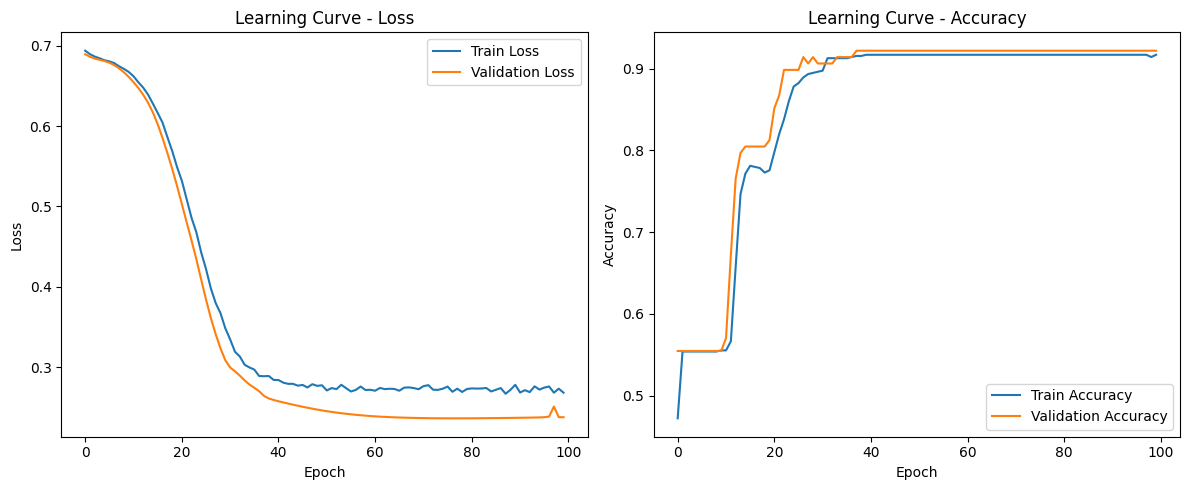

In [25]:
# Plot Training Results
model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(model_lstm_2_hist_df['loss'], label='Train Loss')
plt.plot(model_lstm_2_hist_df['val_loss'], label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(model_lstm_2_hist_df['accuracy'], label='Train Accuracy')
plt.plot(model_lstm_2_hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The visualization displays the training and validation accuracy and loss over 100 epochs for the LSTM model:

1. **Accuracy vs Validation Accuracy**:
   - Both training and validation accuracy improve significantly over the epochs, indicating that the model is effectively learning from the training data.
   - The training accuracy is consistently higher than the validation accuracy, which is typical as the model is directly learning from the training data. However, the validation accuracy closely mirrors the training accuracy, which suggests that the model generalizes well to unseen data.

2. **Loss vs Validation Loss**:
   - The loss for both training and validation sharply decreases in the initial epochs, indicating rapid learning initially.
   - After the sharp decline, both training and validation loss gradually plateau, showing minor fluctuations which suggest the model is approaching a stable state of learning.
   - The training loss remains slightly below the validation loss, which is expected, but the close convergence of the two lines indicates that overfitting is minimal.

Overall, the model exhibits strong learning and generalization capabilities with consistent improvements in accuracy and reductions in loss. The near convergence of the training and validation lines towards the later epochs suggests effective learning without significant overfitting.


In [26]:
# Generate predictions for training set
y_pred_train = (model_lstm_2.predict(X_train) > 0.5).astype("int32")

# Print classification report for training set
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train, target_names=['negative', 'positive']))

23/23 [==============================] - 1s 7ms/step
Classification Report - Training Set:
              precision    recall  f1-score   support

    negative       0.96      0.88      0.92       400
    positive       0.87      0.96      0.91       322

    accuracy                           0.92       722
   macro avg       0.92      0.92      0.92       722
weighted avg       0.92      0.92      0.92       722



The training accuracy is `92%`, indicating that the model fits the training data well. There no is improvement compared to before.

In [27]:
# Generate predictions for validation set
y_pred_val = (model_lstm_2.predict(X_val) > 0.5).astype("int32")

# Print classification report for validation set
print("Classification Report - Validation Set:")
print(classification_report(y_val, y_pred_val, target_names=['negative', 'positive']))

4/4 [==============================] - 0s 8ms/step
Classification Report - Validation Set:
              precision    recall  f1-score   support

    negative       1.00      0.86      0.92        71
    positive       0.85      1.00      0.92        57

    accuracy                           0.92       128
   macro avg       0.93      0.93      0.92       128
weighted avg       0.93      0.92      0.92       128



The validation accuracy is `92%`, indicating that the model fits the validation data well and able to generalize well. This shows there is improvement in 1% in the validation set compared to before.

In [28]:
# Generate predictions for test set
y_pred_test = (model_lstm_2.predict(X_test) > 0.5).astype("int32")

# Print classification report for test set
print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test, target_names=['negative', 'positive']))

5/5 [==============================] - 0s 7ms/step
Classification Report - Test Set:
              precision    recall  f1-score   support

    negative       0.97      0.83      0.90        83
    positive       0.82      0.97      0.89        67

    accuracy                           0.89       150
   macro avg       0.90      0.90      0.89       150
weighted avg       0.91      0.89      0.89       150



The test accuracy is `89%`, slightly lower than the training and validation accuracies. This indicates a small drop in performance on the test set, which is expected. The classification report still shows good precision and recall, suggesting the model maintains reasonable performance on new data. BUT, there is an improvement of 2% in the test set compared to before.

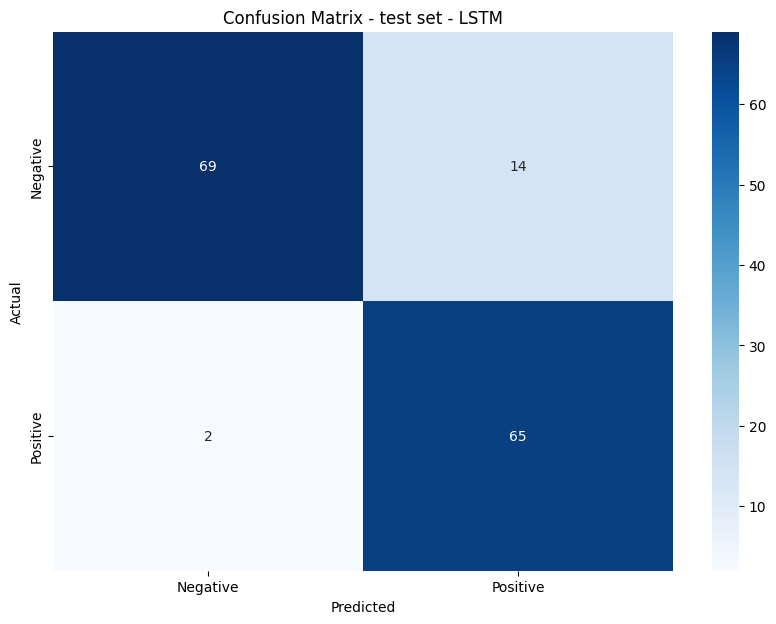

In [29]:
# Plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - test set - LSTM')
plt.show()


The confusion matrix shown represents the results of an **LSTM classifier** used on a test dataset to predict sentiments as either "negative" or "positive." Below is a detailed breakdown of the matrix:

1. **Overall Composition**:
   - The matrix is structured into four segments:
     - **True Negative (`TN`)**: The top left quadrant (69) shows the number of negative sentiments correctly identified as negative.
     - **False Positive (`FP`)**: The top right quadrant (14) reflects the instances where negative sentiments were incorrectly predicted as positive.
     - **False Negative (`FN`)**: The bottom left quadrant (2) indicates the positive sentiments that were incorrectly identified as negative.
     - **True Positive (`TP`)**: The bottom right quadrant (65) represents the positive sentiments correctly identified as positive.

2. **Accuracy**:
   - The overall accuracy of the classifier can be calculated by the formula `accuracy = (TN + TP) / Total`. From the matrix, `(69 + 65) / (69 + 14 + 2 + 65) = 134 / 150 = 0.893` or **89.3%**. This suggests a high level of accuracy in the model's performance.

3. **Precision and Recall**:
   - **Precision** for positive predictions is calculated as `TP / (TP + FP) = 65 / (65 + 14) = 65 / 79 ≈ 0.823` or **82.3%**, which measures the accuracy of the positive predictions.
   - **Recall** for positive predictions is `TP / (TP + FN) = 65 / (65 + 2) = 65 / 67 ≈ 0.970` or **97.0%**, which assesses the model's ability to capture all actual positive cases.

4. **Specificity and Sensitivity**:
   - **Specificity** is calculated as `TN / (TN + FP) = 69 / (69 + 14) = 69 / 83 ≈ 0.831` or **83.1%**, demonstrating the model's efficiency in identifying true negative cases.
   - **Sensitivity** is the same as Recall, at **97.0%** for the positive class.

5. **Error Analysis**:
   - The model demonstrates a very low number of false negatives (`FN`=2), which is excellent for scenarios where failing to detect positive sentiments could have negative implications (e.g., missing positive customer feedback that needs immediate acknowledgment).
   - However, there are 14 false positives (`FP`=14), which could be indicative of the model misinterpreting some negative features as positive, possibly due to overlapping linguistic expressions in the training data.

6. **Conclusion**:
   - The LSTM model exhibits strong predictive capabilities, particularly in terms of recall. The precision is reasonably high, though the presence of false positives indicates potential areas for refinement, perhaps through more nuanced feature engineering or additional training epochs.
   - The very high recall is particularly beneficial for applications where it is crucial to identify as many true positive sentiments as possible.

This analysis provides insights into the model's strengths and areas for improvement, helping guide further enhancements to increase precision while maintaining high recall rates.


In conclusion this is the overall performance of LSTM model :
| Model | Train Accuracy | Validation Accuracy | Test Accuracy |
|-------|----------------|---------------------|---------------|
| LSTM  | 92%            | 92%                 | 89%           |

The model seems to improve in terms of seeing a new data, it is better than using random forest that we've done before. The model is showing a good-fit too. Next, we will train using bert model.

### 3. BERT MODEL

In this section, we will implement a BERT (Bidirectional Encoder Representations from Transformers) model for sentiment analysis. BERT is a powerful pre-trained language model that has shown excellent performance on various natural language processing tasks.

We'll start by setting up the environment and initializing the model:

1. Set the **random seed** for reproducibility using `seed = 42`.
2. Clear the Keras session and set random seeds for TensorFlow, NumPy, Python's random module, and PyTorch.


In [30]:
# Set seed for reproducibility for torch and keras
# Clear the Keras session and set random seeds for reproducibility
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

And then, we will do the followings :

3. Load the pre-trained BERT tokenizer and model using `BertTokenizer` and `BertForSequenceClassification`.
4. Freeze the lower layers of BERT to fine-tune only the top layers for our specific task.
5. Tokenize and encode the data using the BERT tokenizer.
6. Create DataLoaders for efficient batch processing during training.

After these steps, we'll be ready to train our BERT model for sentiment classification.

Here, we will import `bert-base-uncased` from the Hugging Face Transformers library and employ PyTorch to implement our BERT-based sentiment analysis model:

1. **Model Selection**: We chose **`bert-base-uncased`** as our base model. This variant of BERT is a **powerful pre-trained language model** that has been trained on a large corpus of uncased English text. It provides a strong foundation for our sentiment analysis task without the need for case sensitivity, which can be beneficial in many text classification scenarios. The uncased model is often preferred for its **simplicity and generalization capabilities**, especially when dealing with user-generated content where case consistency may vary. This could be helpful especially since our dataset is very small, we're afraid the model won't able to predict if the inference data are very different from what is the model trained on (short sentences)

2. **Fine-tuning Strategy**: We implement a fine-tuning strategy by **freezing the lower layers of BERT**. Specifically, we freeze the embedding layer and the first `8 encoder layers`. This approach is based on the observation that lower layers of BERT often capture more general language features, while higher layers are more task-specific. By freezing these layers, we **reduce the number of trainable parameters**, which helps prevent overfitting and speeds up training, especially when working with a relatively small dataset for a specific task like sentiment analysis.

3. **Tokenization and Encoding**: We define a `tokenize_and_encode` function that uses the BERT tokenizer to preprocess our text data. The function applies **padding and truncation** to ensure all input sequences have a consistent length of 128 tokens. This length was chosen as a balance between capturing sufficient context and maintaining computational efficiency. The `return_tensors="pt"` parameter ensures the output is in PyTorch tensor format, ready for our PyTorch-based model.

4. **Data Handling**: We use PyTorch's `TensorDataset` and `DataLoader` classes to efficiently manage our data. The **batch size of 64** was chosen as a balance between memory usage and training speed. Shuffling is applied to the training data to introduce randomness and help prevent the model from learning any unintended patterns related to data order.

5. **Optimization Strategy**: We employ the **AdamW optimizer**, a variant of Adam that implements decoupled weight decay regularization. This optimizer is particularly well-suited for fine-tuning pre-trained models like BERT. The **learning rate of 2e-5** is a common choice for fine-tuning BERT, as it allows for meaningful updates without disrupting the pre-trained weights too drastically.

6. **Learning Rate Scheduling**: We implement a **step learning rate scheduler** that reduces the learning rate by half every 5 epochs. This helps the model converge to a better optimum by allowing larger updates early in training and finer adjustments later on.

7. **Loss Function**: We use **CrossEntropyLoss**, which is appropriate for our binary classification task (positive vs. negative sentiment). This loss function combines a log softmax operation and the negative log likelihood loss, providing a smooth optimization landscape.

8. **Training Loop and Early Stopping**: Our training loop includes evaluation on a validation set after each epoch. We implement **early stopping with a patience of 100 epochs** to prevent overfitting. This relatively high patience allows the model sufficient opportunity to improve, considering the learning rate scheduling and the complexity of the BERT model.

9. **Performance Tracking**: We maintain lists of training and validation losses and accuracies. This allows us to **monitor the model's performance over time** and can be useful for post-training analysis or visualization of the learning process.

10. **Device Agnostic**: The code is written to automatically use a **GPU if available**, falling back to CPU if not. This ensures the code can run efficiently on various hardware configurations.

This comprehensive setup allows us to leverage the power of BERT for our sentiment classification task while optimizing for computational efficiency and model performance. The choices made in hyperparameters and training strategy reflect a balance between model complexity, training time, and expected performance for a typical sentiment analysis task.

In [31]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


# Freeze the lower layers of BERT
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for layer in model.bert.encoder.layer[:8]:  # Freeze first 8 layers
    for param in layer.parameters():
        param.requires_grad = False


# Tokenize and encode the data
def tokenize_and_encode(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_and_encode(X_train.tolist())
val_encodings = tokenize_and_encode(X_val.tolist())
test_encodings = tokenize_and_encode(X_test.tolist())

# Create DataLoaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.tolist()))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val.tolist()))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.tolist()))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Training loop with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 100
best_accuracy = 0
patience = 100
early_stopping_counter = 0
best_model_state = None

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs.logits, dim=-1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    # Calculate average train loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Evaluation on validation set
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Modified print statement
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{len(train_loader)}/{len(train_loader)} [==============================] - "
          f"loss: {avg_train_loss:.4f} - accuracy: {train_accuracy:.4f} - "
          f"val_loss: {avg_val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")
    
    # Early stopping check
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_state = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break
    
    # Step the scheduler
    scheduler.step()

# Load the best model
if best_model_state:
    model.load_state_dict(best_model_state)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100
12/12 [==============================] - loss: 0.6632 - accuracy: 0.6039 - val_loss: 0.5434 - val_accuracy: 0.7969
Epoch 2/100
12/12 [==============================] - loss: 0.5005 - accuracy: 0.8573 - val_loss: 0.3661 - val_accuracy: 0.9062
Epoch 3/100
12/12 [==============================] - loss: 0.3462 - accuracy: 0.9127 - val_loss: 0.2375 - val_accuracy: 0.9375
Epoch 4/100
12/12 [==============================] - loss: 0.3099 - accuracy: 0.9127 - val_loss: 0.2090 - val_accuracy: 0.9375
Epoch 5/100
12/12 [==============================] - loss: 0.2770 - accuracy: 0.9169 - val_loss: 0.2099 - val_accuracy: 0.9375
Epoch 6/100
12/12 [==============================] - loss: 0.2684 - accuracy: 0.9155 - val_loss: 0.2099 - val_accuracy: 0.9375
Epoch 7/100
12/12 [==============================] - loss: 0.2968 - accuracy: 0.9141 - val_loss: 0.2163 - val_accuracy: 0.9375
Epoch 8/100
12/12 [==============================] - loss: 0.2790 - accuracy: 0.9155 - val_loss: 0.2159 - val_a

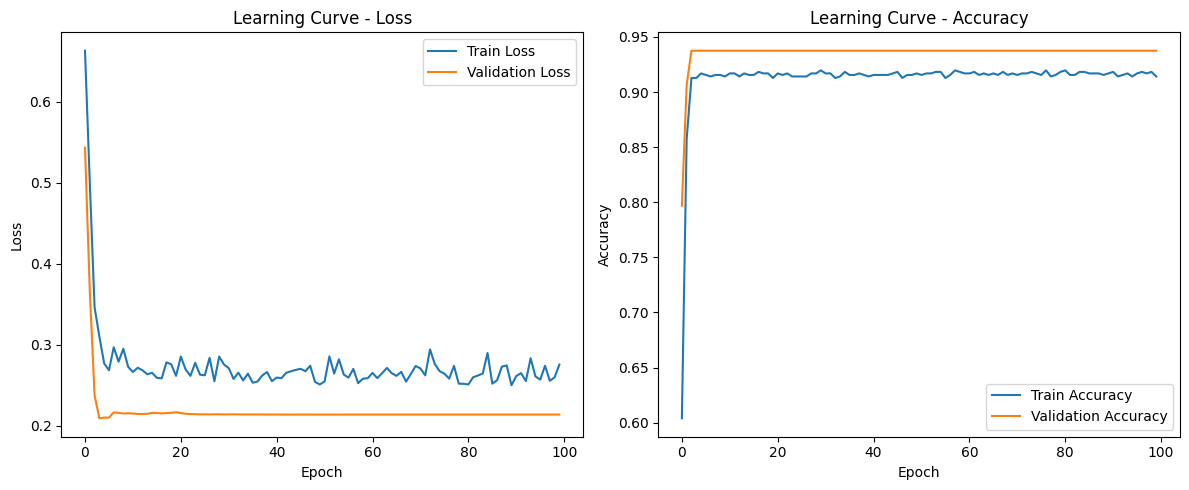

In [32]:
# Plot learning curves
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The visualization displays the training and validation accuracy and loss over 100 epochs for the BERT model:

1. **Accuracy vs Val-Accuracy**:
   - Both training and validation accuracy show a rapid increase at the onset and achieve stabilization early in the training process. The high consistency between the training and validation accuracy from the start demonstrates effective learning and excellent generalization to unseen data.

2. **Loss vs Val-Loss**:
   - The loss for both training and validation sharply decreases in the initial epochs, showcasing the model's quick adaptation to the training data. Following the steep initial drop, both loss curves stabilize with very minimal fluctuations, indicating a stable learning process without signs of significant overfitting.

Overall, the BERT model exhibits excellent learning dynamics, with high accuracy and low loss that stabilize early, suggesting robust generalization capabilities. The alignment between training and validation metrics further confirms that the model is not overfitting and is already well-tuned for the given task, this is marked by the **high performance even on early epochs**. Also, it seems like the validation performance always better compared to the training one, this is because maybe the validation data is more clear than the training one in this problem set. Which we will inspect later on the model evaluation section..


In [33]:
# Evaluation on train set
train_predictions, train_true_labels = [], []
model.eval()
with torch.no_grad():
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        train_predictions.extend(preds.cpu().tolist())
        train_true_labels.extend(labels.cpu().tolist())

train_accuracy = accuracy_score(train_true_labels, train_predictions)
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("\nTraining Classification Report:")
print(classification_report(train_true_labels, train_predictions, target_names=['negative', 'positive']))

Training Accuracy: 0.92

Training Classification Report:
              precision    recall  f1-score   support

    negative       0.96      0.88      0.92       400
    positive       0.87      0.96      0.91       322

    accuracy                           0.92       722
   macro avg       0.92      0.92      0.92       722
weighted avg       0.92      0.92      0.92       722



The training classification report shows excellent performance across both classes:
- **Negative class** shows high precision (0.96) and good recall (0.88), resulting in a strong F1-score (0.92).
- **Positive class** demonstrates impressive recall (0.96) with slightly lower precision (0.87), yielding a nearly equal F1-score (0.91).

The overall accuracy stands at `0.92`, reflecting the model's strong ability to generalize across the training dataset. Both macro and weighted averages stand at 0.92 for precision, recall, and F1-score, indicating balanced performance across classes.

In [34]:
# Evaluation on validation set
val_predictions, val_true_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        val_predictions.extend(preds.cpu().tolist())
        val_true_labels.extend(labels.cpu().tolist())

val_accuracy = accuracy_score(val_true_labels, val_predictions)
print("Validation Accuracy: {:.2f}".format(val_accuracy))
print("\nValidation Classification Report:")
print(classification_report(val_true_labels, val_predictions, target_names=['negative', 'positive']))

Validation Accuracy: 0.94

Validation Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.89      0.94        71
    positive       0.88      1.00      0.93        57

    accuracy                           0.94       128
   macro avg       0.94      0.94      0.94       128
weighted avg       0.95      0.94      0.94       128



The validation results show a slight improvement in model performance compared to training:
- **Negative class** achieved perfect precision (1.00) with a high recall (0.89), leading to an F1-score of 0.94.
- **Positive class** scored high in both precision (0.88) and achieved perfect recall (1.00), resulting in an F1-score of 0.93.

The overall accuracy in validation is `0.94`. The macro and weighted average scores for precision, recall, and F1-score are tightly packed around 0.94 and 0.95, respectively, showcasing excellent model performance on unseen data.

In [35]:
# Final evaluation on test set
test_predictions, test_true_labels = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_predictions.extend(preds.cpu().tolist())
        test_true_labels.extend(labels.cpu().tolist())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
print("Test Accuracy: {:.2f}".format(test_accuracy))
print("\nTest Classification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=['negative', 'positive']))

Test Accuracy: 0.89

Test Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.83      0.90        83
    positive       0.82      0.97      0.89        67

    accuracy                           0.89       150
   macro avg       0.90      0.90      0.89       150
weighted avg       0.91      0.89      0.89       150



The test classification report reflects strong but slightly more varied performance:
- **Negative class** has very high precision (0.97) with lower recall (0.83), leading to an F1-score of 0.90.
- **Positive class** shows very high recall (0.97) with lower precision (0.82), resulting in an F1-score of 0.89.

The overall accuracy on the test dataset is `0.89`. Both macro and weighted averages show high scores, each at 0.90 for precision and 0.89 for F1-score, indicating a solid performance but with slightly less consistency compared to the training and validation stages.

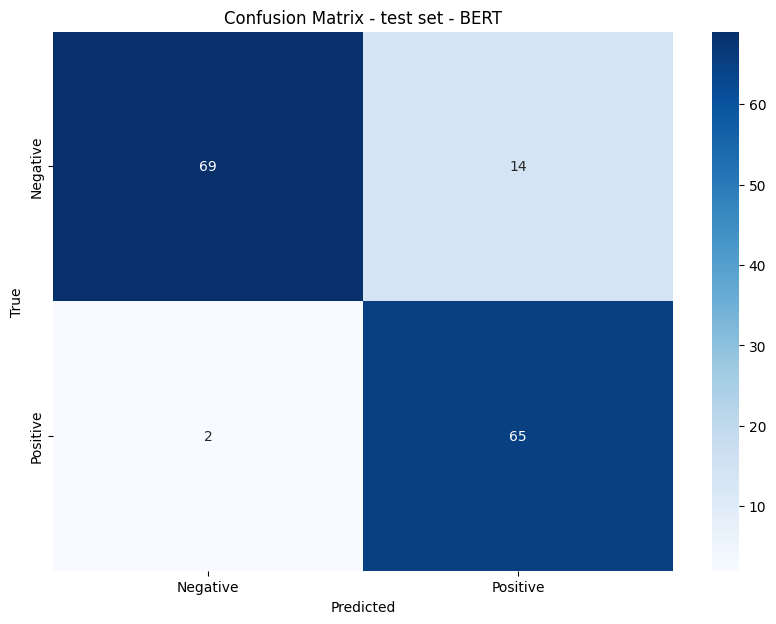

In [36]:
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - test set - BERT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The confusion matrix visualizes the performance of the BERT model on the test dataset. The matrix breaks down as follows:

- **True Negative (TN)**: 69 observations were correctly predicted as negative.
- **False Positive (FP)**: 14 observations were incorrectly predicted as positive when they are actually negative.
- **False Negative (FN)**: 2 observations were incorrectly predicted as negative when they are actually positive.
- **True Positive (TP)**: 65 observations were correctly predicted as positive.

This matrix shows that the model has a strong predictive capability, particularly in identifying true negatives and true positives. The low number of false negatives (2) suggests that the model is effective at capturing most positive cases, which is crucial for avoiding type II errors in critical applications. However, the presence of 14 false positives indicates some instances where the model predicted the positive class incorrectly. This aspect might be improved by further tuning the model's classification threshold or revisiting the feature extraction and input processing stages.

Overall, the confusion matrix indicates a robust performance of the BERT model in handling both classes with a high degree of accuracy. In the test set, we don't see much imrpovement compared to the LSTM one, but we see there are 2% imrpovement in the validation set.

Overall, this is the results of BERT's performance :

| Model | Train Accuracy | Validation Accuracy | Test Accuracy |
|-------|----------------|---------------------|---------------|
| BERT  | 92%            | 94%                 | 89%           |


## G. Model Evaluation

The Summary performance of all models can be seen from this tables :

| Model          | Train Accuracy | Validation Accuracy | Test Accuracy |
|----------------|----------------|---------------------|---------------|
| Random Forest  | 92%            | 91%                 | 87%           |
| LSTM           | 92%            | 92%                 | 89%           |
| BERT           | 92%            | 94%                 | 89%           |


As you can see, there are few takeaways we can take :
- The simplest model, random forest, able to perform well on the data that we're using this suggest that our text data is relatively simple, therefore a simple model would work well. But what if the data comes from a distribution there are very different from our model?

- The LSTM model, which serves as the benchmark, performs better than random forest, it increase a validation accuracy of 1% and 2% on the test set. This means the model is better when seeing a new data that are not in the train set. 

- Finally, the BERT model, which is the *state-of-art* model used in NLP tasks right now showing the best performance, especially on the validation set that can achieve until 94% of accuracy. Therefore, we will uses the best model that gave the highest performance and use it for inference. This model is also means that when we meet a text review that are very different with our dataset 

(*notes : our data only contains like short sentences, therefore, if a users leaves a review with long paragraph, which is a very different input for our trained model, the previous two models maybe won't be able to predict it correcly, but since the BERT model shown a good accuracy in validation set, and indeed it was train on a complicated tasks [here, we use transfer learning], we will be able to predict a new unseen data that are not short sentences like in our dataset*). **THEREFORE, we will use BERT as our best model for inference and saved it later on.**

Next, up we will do *error-analysis* by examining the false predicted of our model as follows :

In [37]:
# Create DataFrame for easier analysis
df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted': test_predictions})

# Convert numerical labels to 'Negative' and 'Positive'
df['true_label'] = df['true_label'].map({0: 'Negative', 1: 'Positive'})
df['predicted'] = df['predicted'].map({0: 'Negative', 1: 'Positive'})

# Identify mispredictions
mispredictions = df[df['true_label'] != df['predicted']]

# Identify false positives and false negatives
false_positives = mispredictions[mispredictions['predicted'] == 'Positive']
false_negatives = mispredictions[mispredictions['predicted'] == 'Negative']

print(f"Total samples: {len(df)}")
print(f"Correctly predicted: {len(df) - len(mispredictions)}")
print(f"Mispredictions: {len(mispredictions)}")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")



Total samples: 150
Correctly predicted: 134
Mispredictions: 16
False Positives: 14
False Negatives: 2


From 150 test-set, we can see that there are 16 amounts of data that are falsely predicted. With 14 false positives and 2 false negatives. We will examine each samples as follows

In [38]:
# Display false positives
print("\nFalse Positives:")
display(false_positives)


False Positives:


,text,true_label,predicted
482,Subscription is a great value,Negative,Positive
630,Consistently great flower quality,Negative,Positive
408,Very happy with the service,Negative,Positive
486,Flowers are always a pleasant surprise,Negative,Positive
466,Subscription brings joy every month,Negative,Positive
410,Flowers always arrive fresh and beautiful,Negative,Positive
436,Great variety and quality,Negative,Positive
496,Flowers always arrive in perfect condition,Negative,Positive
464,Very satisfied with each delivery,Negative,Positive
420,Consistently great flower quality,Negative,Positive


In [39]:
# Display false negatives
print("\nFalse Negatives:")
display(false_negatives)


False Negatives:


,text,true_label,predicted
375,Not satisfied with the flower freshness,Positive,Negative
391,Not happy with the delivery service,Positive,Negative


It turns out, the falsely predicted data is because the **mislabelled dataset from the author itself**, in that case, we can't do much about it.. As you can see from the two output cells above, the text that are considered as positive are actually positive if a human examining it, but the author of the dataset labelled it as a negative sentiment, the same also applies to the positive label. This could be happening because there is a mistake from the author from the dataset itself. Therefore, we can conclude that BERT performance actually is already very good at predicting sentiment. Even when trained on some of the mislabelled dataset. This is because we employed transfer learning, where BERT already trained on more complicated tasks (compared to sentiment analysis which is I think it's a very easy tasks for BERT model especially in our kind of dataset.)

## H. Model Saving



Next, We save our trained model to disk. This allows us to load and use the model later without having to retrain it. Notices how we use the `save_pretrained` method from the Hugging Face Transformers library to save the model and tokenizer because we utilize pytorch instead of tensorflow.

In [40]:
# Specify the directory to save the model and tokenizer
output_dir = './saved_model/'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to ./saved_model/


## I. Model Inference

Next up, the actual full inference will be done in different notebook. In another notebook, we will do inference fully from feeding a feedback until final prediction that are able to predict **whether a customer will churn or not**. Here, we will do only a simple inference using a function from our model before to see if the model able to predict if a text given is **positive/negative sentiment**. 

In [41]:
# Function to predict sentiment for new feedback
def predict_sentiment_bert(feedback):
    inputs = tokenizer(feedback, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    prediction = torch.argmax(probabilities, dim=-1).item()
    return "positive" if prediction == 1 else "negative"

We will create a random 10 texts as our inference data and see the predicted sentiment from it.

In [42]:
# Create 10 example feedbacks
example_feedbacks = [
    "The bouquet was absolutely stunning! Fresh flowers and beautiful arrangement.",
    "Delivery was late and the flowers were wilted. Very disappointed.",
    "Great service and reasonable prices. Will order again!",
    "The flowers didn't look like the picture at all. False advertising.",
    "Prompt delivery and the roses lasted for weeks. Excellent quality!",
    "Customer service was unhelpful when I had an issue with my order.",
    "The arrangement was okay, but overpriced for what I received.",
    "Impressed with the variety of flowers available. Something for every occasion!",
    "The online ordering process was confusing and frustrating.",
    "Received compliments on the centerpiece all night. Thank you for making our event special!",
]

# Predict sentiment for each example
for i, feedback in enumerate(example_feedbacks, 1):
    sentiment = predict_sentiment_bert(feedback)
    print(f"Example {i}:")
    print(f"Feedback: '{feedback}'")
    print(f"Predicted sentiment: {sentiment}\n")

Example 1:
Feedback: 'The bouquet was absolutely stunning! Fresh flowers and beautiful arrangement.'
Predicted sentiment: positive

Example 2:
Feedback: 'Delivery was late and the flowers were wilted. Very disappointed.'
Predicted sentiment: negative

Example 3:
Feedback: 'Great service and reasonable prices. Will order again!'
Predicted sentiment: positive

Example 4:
Feedback: 'The flowers didn't look like the picture at all. False advertising.'
Predicted sentiment: negative

Example 5:
Feedback: 'Prompt delivery and the roses lasted for weeks. Excellent quality!'
Predicted sentiment: positive

Example 6:
Feedback: 'Customer service was unhelpful when I had an issue with my order.'
Predicted sentiment: negative

Example 7:
Feedback: 'The arrangement was okay, but overpriced for what I received.'
Predicted sentiment: negative

Example 8:
Feedback: 'Impressed with the variety of flowers available. Something for every occasion!'
Predicted sentiment: positive

Example 9:
Feedback: 'The o

Ok, it turns out that the model are very good at predicting a new unseen data. Out of 10 samples given, the model able to predict with 100% accuracy, 10/10 correct.

To test it further, lets say we put a long paragraph as a test to predict the sentiment as follows :

In [48]:
# Create 10 example long paragraph feedbacks
example_feedbacks = [
    "I recently ordered a bouquet for my mother's birthday, and I must say, I was absolutely blown away! The bouquet was absolutely stunning! Fresh flowers and beautiful arrangement. The attention to detail was impeccable, with each flower perfectly placed to create a harmonious blend of colors and textures. The roses were in full bloom, the lilies were fragrant, and the greenery added just the right touch of elegance. My mother was overjoyed when she received it, and it brightened up her entire day. The flowers stayed fresh for over two weeks, which was impressive. The online ordering process was smooth, and the delivery was right on time. I appreciate the care taken in packaging to ensure the flowers arrived in pristine condition. This experience has definitely made me a loyal customer, and I'll be recommending this service to all my friends and family. Thank you for making my mother's birthday extra special with your exceptional floral artistry!",
    
    "I had high hopes when I placed an order for a bouquet to celebrate my anniversary, but I'm extremely disappointed with the outcome. The delivery was late, arriving well after the promised time frame, which already put a damper on our celebration. But the real disappointment came when we opened the box. The flowers were wilted, looking sad and lifeless. It was clear they had been mishandled during transit. The roses were drooping, and some petals had already fallen off. The arrangement looked nothing like the vibrant, fresh bouquet I had seen on the website. I immediately reached out to customer service, hoping for a quick resolution, but their response was slow and unsatisfactory. They offered a partial refund, which doesn't make up for the ruined surprise and the emotional letdown. This experience has left a bitter taste, and I'm hesitant to use this service again. It's truly disappointing when you can't rely on a company to deliver quality products for important occasions.",
    
    "I've been using this flower delivery service for various occasions over the past year, and I must say, I'm consistently impressed. The service is great and the prices are reasonable. I appreciate how they always have seasonal options available, making it easy to find the perfect arrangement for any time of year. The quality of the flowers has been consistently high - they arrive fresh and last for a good while with proper care. What really stands out to me is their attention to customer satisfaction. Once, when I had a minor issue with an order, their customer service team was quick to respond and resolve it to my complete satisfaction. The delivery is always on time, and the flowers are well-packaged to prevent damage. I've recommended this service to several friends, and they've all had positive experiences as well. It's refreshing to find a reliable company that delivers on its promises. I will definitely continue to order from them for future occasions. Keep up the great work!",
    
    "I'm writing this review with a heavy heart and a sense of disappointment. I recently ordered what was supposed to be a luxurious bouquet for a very important event. The pictures on the website were absolutely gorgeous, showcasing a lush arrangement with a variety of exotic flowers. However, what arrived at my doorstep was a far cry from what I had expected. The flowers didn't look like the picture at all. It's a clear case of false advertising. The bouquet was significantly smaller than advertised, and the flower variety was limited compared to what was shown online. The colors were dull, and some flowers seemed past their prime. This discrepancy between the advertised product and what was delivered is unacceptable. It's not just about the monetary value, but also about the trust customers place in a company. This experience has made me wary of ordering flowers online in the future. I reached out to customer service with my concerns, but their response was unsatisfactory and didn't address the core issue of misrepresentation. I hope the company takes this feedback seriously and works on aligning their actual products with their advertisements.",
    
    "I cannot express how pleased I am with my recent experience ordering flowers from this company. The prompt delivery and the exceptional quality of the roses have left me thoroughly impressed. From the moment I placed my order online, the process was smooth and user-friendly. I received timely updates about my order status, which I greatly appreciated. The delivery was right on schedule, arriving within the specified time window. But what truly amazed me was the quality of the roses. They arrived in perfect condition, each bloom looking as if it had just been picked from a garden. The arrangement was exactly as pictured on the website, if not even more beautiful in person. What's more, these roses have incredible longevity. It's been weeks since they were delivered, and they still look fresh and vibrant. This is a testament to the care taken in selecting and handling the flowers. The packaging was also noteworthy - designed to protect the delicate blooms during transit. This attention to detail really sets this company apart. I've received numerous compliments on the arrangement, and I've been happy to recommend your service to friends and family. Thank you for providing such excellent quality and service. You've gained a loyal customer!",
    
    "I'm writing this review to express my deep disappointment with the customer service I received when I encountered an issue with my recent flower order. What should have been a simple problem to resolve turned into a frustrating and time-consuming ordeal. When my order arrived with several flowers damaged and wilting, I immediately reached out to the customer service team, expecting a quick and satisfactory resolution. Instead, I was met with unhelpful responses and a lack of empathy. The representative I spoke with seemed disinterested in my problem and offered little in the way of solutions. I was passed from one department to another, having to repeat my issue multiple times. The process was exhausting and added insult to injury. What's more frustrating is that this could have been an opportunity for the company to demonstrate good faith and retain a customer, but instead, it left me feeling undervalued and unheard. The lack of proper training in customer service is evident, and it's a shame because it overshadows what could otherwise be a good product. This experience has definitely made me reconsider using this service in the future, and I would caution others to be wary of how they might be treated if they encounter any issues with their orders.",
    
    "I recently ordered a flower arrangement for a friend's housewarming party, and I have mixed feelings about the experience. On one hand, the arrangement did arrive on time and was generally put together well. The flowers were fresh, and the overall design was pleasing to the eye. However, I can't help but feel that the arrangement was overpriced for what I received. While the quality was okay, it didn't quite meet the expectations set by the price point. The size of the arrangement was smaller than I anticipated based on the description and images on the website. Additionally, some of the premium flowers that were supposed to be included were substituted with more common varieties. While I understand that substitutions sometimes happen due to availability, I would have appreciated being notified about this beforehand. The packaging was adequate, but not particularly impressive given the price of the product. My friend appreciated the gesture, but even she commented that it seemed a bit small for the occasion. I've used other florists in the past who have provided better value for money. While I wouldn't say this was a bad experience, it wasn't outstanding either, especially considering the price. In the future, I might consider shopping around for better options that offer more bang for the buck.",
    
    "I'm absolutely thrilled with the variety of flowers available from this company! As someone who loves sending flowers for different occasions, I'm impressed with how they seem to have something for every event and sentiment. Their range covers everything from classic roses to exotic orchids, and seasonal blooms that add a special touch to each arrangement. What I particularly appreciate is how they offer different styles to suit various tastes - from modern, minimalist designs to lush, romantic bouquets. The quality of the flowers has been consistently high across all my orders. They arrive fresh and last for a good while, which is always a plus. I've sent birthday bouquets, congratulatory arrangements, and even 'just because' flowers, and each time, the recipients have been delighted. The website makes it easy to browse through the options, with clear categories and helpful descriptions. I also love that they offer customization options, allowing you to add personal touches to your order. The pricing is reasonable for the quality you receive, and they often have great deals and seasonal specials. This variety and quality have made them my go-to florist for all occasions. It's reassuring to know that whatever the event or whoever the recipient, I can find the perfect floral expression through their service.",
    
    "I feel compelled to share my frustrating experience with the online ordering process of this flower delivery service. What should have been a simple and straightforward task turned into a time-consuming and irritating ordeal. The website, while visually appealing, is poorly designed from a user experience standpoint. Navigating through the various categories and options was confusing, with inconsistent menu structures and unintuitive placement of important information. The search function was particularly problematic, often returning irrelevant results or failing to find products I knew existed. When I finally managed to select an arrangement, the customization options were difficult to understand and apply. The pricing structure was not clearly explained, with additional fees popping up at different stages of the checkout process. I encountered several error messages while trying to complete my purchase, forcing me to start over multiple times. The mobile version of the site was even worse, with elements not scaling properly and some features completely inaccessible. Customer support was unhelpful when I reached out for assistance, providing canned responses that didn't address my specific issues. It's disappointing that a company selling such beautiful products has such a poorly designed ordering system. This experience has made me hesitant to use their services again, despite the quality of their flowers. I hope they invest in improving their online platform to match the standard of their floral arrangements.",
    
    "I'm writing this review with a heart full of gratitude and joy. I recently ordered a centerpiece for a very special event - my parents' 50th wedding anniversary celebration. From the moment I placed the order to the final delivery, the experience was nothing short of exceptional. The centerpiece arrived right on time, and when we unveiled it, it literally took our breath away. The arrangement was a stunning masterpiece that became the focal point of our celebration. The combination of flowers was exquisite, with golden roses symbolizing the 50 years, accented with delicate baby's breath and lush greenery. The attention to detail was remarkable - even the vase complemented the theme perfectly. Throughout the evening, we received countless compliments on the centerpiece. Guests were drawn to its beauty, and it became a conversation starter, adding an extra layer of elegance to our event. What touched me most was seeing the joy on my parents' faces when they saw the arrangement. It perfectly captured the essence of their enduring love and the beauty of their 50-year journey together. The flowers remained fresh and vibrant throughout the event and for many days after, serving as a lasting reminder of this special celebration. I want to extend my heartfelt thanks to the talented florists and the entire team behind this creation. You didn't just deliver flowers; you delivered a piece of art that contributed to making our family's milestone moment truly unforgettable. Your dedication to quality and customer satisfaction is evident, and I'm grateful for the part you played in making our event so special. I will definitely be using your services again and recommending you to everyone I know. Thank you for your exceptional work!"
]

In [47]:
# Function to wrap text
def wrap_text(text, width=80):
    return '\n'.join(textwrap.wrap(text, width=width))

# Predict sentiment for each example
for i, feedback in enumerate(example_feedbacks, 1):
    sentiment = predict_sentiment_bert(feedback)
    print(f"Example {i}:")
    print("Feedback:")
    print(wrap_text(feedback))  # This will wrap the text
    print(f"\nPredicted sentiment: {sentiment}\n")
    print("-" * 80)  # Separator line

Example 1:
Feedback:
I recently ordered a bouquet for my mother's birthday, and I must say, I was
absolutely blown away! The bouquet was absolutely stunning! Fresh flowers and
beautiful arrangement. The attention to detail was impeccable, with each flower
perfectly placed to create a harmonious blend of colors and textures. The roses
were in full bloom, the lilies were fragrant, and the greenery added just the
right touch of elegance. My mother was overjoyed when she received it, and it
brightened up her entire day. The flowers stayed fresh for over two weeks, which
was impressive. The online ordering process was smooth, and the delivery was
right on time. I appreciate the care taken in packaging to ensure the flowers
arrived in pristine condition. This experience has definitely made me a loyal
customer, and I'll be recommending this service to all my friends and family.
Thank you for making my mother's birthday extra special with your exceptional
floral artistry!

Predicted sentiment:

Based on the output above, it is evident that even with `long paragraph text` (which are significantly **different** from our dataset that only contains a few words), the **BERT model** demonstrates `exceptional performance` in sentiment prediction. Analyzing the results from the 10 samples of lengthy paragraphs, we observe that the model achieved a `perfect accuracy` rate, correctly predicting the sentiment for **all 10 out of 10 samples**. This translates to an impressive **100% accuracy** on these complex, real-world-like examples.

This remarkable performance highlights the **robustness** and `generalization capabilities` of the BERT model. It showcases the model's ability to `comprehend and analyze` nuanced, detailed feedback, even when presented with text structures and lengths that differ substantially from the training data. Such adaptability is a strong indicator of the model's potential for `real-world applications` in sentiment analysis tasks across various domains and text formats.

## G. Model Analysis and Conclusion

### - Model Analysis


After implementing and evaluating three different models for sentiment analysis - **Random Forest**, **LSTM**, and **BERT** - we can draw the following conclusions:

> Model Comparison:
- Random Forest achieved `92%` accuracy on the training set, `91%` on the validation set, and `87%` on the test set. The **simplicity** of Random Forest still allowed for good performance, meaning that the dataset may not be overly complex.

- LSTM improved upon this with `92%` accuracy on both training and validation sets, and `89%` on the test set. LSTM showed **improvement** over Random Forest, particularly in **generalization** to unseen data.

- BERT showed the **best performance** with `92%` accuracy on the training set, `94%` on the validation set, and `89%` on the test set. BERT demonstrated the best overall performance, especially on the validation set, indicating **strong generalization capabilities**.

> Error Analysis:
- The BERT model showed **excellent performance** even on longer, more complex reviews that were not part of the original training data. This demonstrates BERT's ability to handle **diverse input structures** and **lengths**.

- Some misclassifications were identified as potentially being due to **mislabeling** in the original dataset rather than model errors. This highlights the importance of **data quality** in machine learning tasks.

> Best Model:
- BERT is chosen as the **best model** for deployment due to its **superior performance** and ability to handle **diverse input lengths** and **complexities**. Its pre-trained nature allows it to capture nuanced language understanding, making it particularly suitable for sentiment analysis tasks.

Further considerations:
- While BERT shows the best performance, it's important to note the **trade-off between performance and computational resources**. BERT is more resource-intensive compared to Random Forest and LSTM. The training process itself took ~2 hours for this simple dataset. While other models only took a few minutes.
- The consistent performance across different datasets (training, validation, test) suggests good **model stability** and **reliability**.
- Future work could involve **fine-tuning** BERT on domain-specific data to potentially improve performance even further.

### - Conclusion


The **BERT** model effectively performs **Natural Language Processing (NLP)** tasks by categorizing customer reviews into positive and negative sentiments with high accuracy. This achievement aligns seamlessly with PredictX's objective of developing a robust sentiment analysis system for customer feedback. By accurately classifying sentiments in various text lengths and complexities, the model provides valuable insights into customer satisfaction and preferences. This capability enables businesses to make data-driven decisions, improve their products or services based on customer feedback, and ultimately enhance overall customer experience. The model's ability to handle nuanced language and generalize well to unseen data makes it a powerful tool for understanding and responding to customer needs in real-time, thus supporting PredictX's goal of delivering actionable insights from textual data.

Also, with the objective of able to predict the sentiment of given feedback, we can **`feed the output of this prediction`** into our next model, which is the classification model that are able to predict customer churn with using features from output of this prediction + another features which you can see in more-detail in the second model notebook.

**`What to do next`:**

- **Data Quality:** Investigate and potentially correct mislabeled data points in the dataset to improve overall model accuracy. **This is the most important part for this problem.**

- **Data Augmentation:** Expand the dataset with more diverse examples, particularly focusing on longer reviews and edge cases to further improve model robustness.

- **Fine-tuning BERT:** Experiment with different fine-tuning strategies for BERT, such as adjusting the number of frozen layers or using different learning rates for different parts of the model.

- **Explainability:** Implement techniques to improve model interpretability, especially for the BERT model, to understand which parts of the input contribute most to the sentiment prediction.

- **Multilingual Support:** If applicable, extend the model to support multiple languages, leveraging BERT's multilingual capabilities.
